# VOPY


```
%% Setup
ds = 2; % 0: KITTI, 1: Malaga, 2: parking

% Path containing images, depths and all...
last_frame = 598;
K = load([parking_path '/K.txt']);
ground_truth = load([parking_path '/poses.txt']);
ground_truth = ground_truth(:, [end-8 end]);

img0 = rgb2gray(imread([parking_path ...
    sprintf('/images/img_%05d.png',bootstrap_frames(1))]));
img1 = rgb2gray(imread([parking_path ...
    sprintf('/images/img_%05d.png',bootstrap_frames(2))]));

%% Continuous operation
range = (bootstrap_frames(2)+1):last_frame;
for i = range
    fprintf('\n\nProcessing frame %d\n=====================\n', i);
    image = im2uint8(rgb2gray(imread([parking_path ...
        sprintf('/images/img_%05d.png',i)])));
    % Makes sure that plots refresh.    
    pause(0.01);
    prev_img = image;
end
```

In [ ]:
# Get the data
!cd .. && sh get-data.sh

In [1]:
# Import libraries
import numpy as np
from os import path
import skimage as ski
import skimage.io as skio
from skimage import transform
from scipy import signal
import matplotlib.pyplot as plt

In [2]:
# Define constants
DATASET_PATH = "../data/parking"
LAST_FRAME = 598
IMAGE_RATIO = 0.5

In [3]:
def load_dataset(dataset_path):
    ground_truth = np.loadtxt(path.join(dataset_path, "poses.txt"))   
    K = np.loadtxt(path.join(dataset_path, "K.txt"))

    def load_image(frame):
        im_path = path.join(dataset_path, "images", "img_%05d.png" % frame)
        full_image = skio.imread(im_path, as_gray=True)
        return ski.transform.rescale(full_image, IMAGE_RATIO)
    return load_image, ground_truth, K


get_image, ground_truth, K = load_dataset(DATASET_PATH)

In [4]:
ground_truth

array([[1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.]])

In [5]:
K

array([[331.37 ,   0.   , 320.   ],
       [  0.   , 369.568, 240.   ],
       [  0.   ,   0.   ,   1.   ]])

## Part 1 - Initialization

Estimate relative pose of the camera

### Select initial frames

In [6]:
# Manually select two frames at the beginning of the dataset
i0 = get_image(0)
i1 = get_image(16)

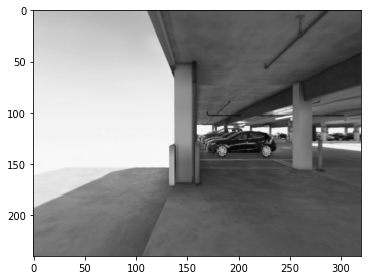

In [7]:
plt.figure()
skio.imshow(i0)

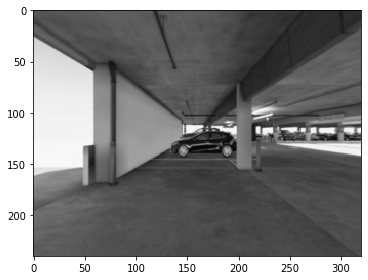

In [8]:
plt.figure()
skio.imshow(i1)

### Estabilish keypoint correspondences

In [9]:
# Parameters
patch_size = 9
harris_kappa = 0.08
num_keypoints = 100
nonmaximum_supression_radius = 8
descriptor_radius = 9
match_lambda = 4

In [10]:
sobel_y = np.array([[1, 2, 1],[0,0,0],[-1,-2,-1]])
sobel_x = sobel_y.T

def harris(img, patch_size, kappa):
    Ix = signal.convolve2d(sobel_x, img, 'valid')
    Iy = signal.convolve2d(sobel_y, img, 'valid')
    Ixx = Ix ** 2
    Iyy = Iy ** 2
    Ixy = Ix * Iy

    patch = np.ones([patch_size, patch_size])
    pr = np.floor(patch_size / 2).astype(int)
    
    sIxx = signal.convolve2d(Ixx, patch, 'valid');
    sIyy = signal.convolve2d(Iyy, patch, 'valid');
    sIxy = signal.convolve2d(Ixy, patch, 'valid');

    scores = (sIxx * sIyy - sIxy ** 2) - kappa * (sIxx + sIyy) ** 2

    return np.pad(scores.clip(min=0), [1+pr, 1+pr]);

In [11]:
harris_score = harris(i0, patch_size, harris_kappa)

/home/ecuba/.local/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


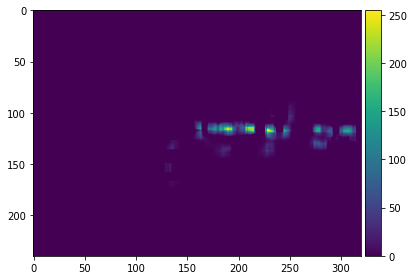

In [12]:
rescaled = harris_score * 255.0/harris_score.max()
plt.figure()
skio.imshow(rescaled)

In [13]:
def select_keypoints(scores, num, r):
    keypoints = np.zeros([num, 2])
    temp_scores = np.pad(scores, [r, r])
    zero_patch = np.zeros([2*r + 1, 2*r + 1])
    
    for i in range(num):
        kp = np.argmax(temp_scores, axis=None)
        x, y = np.unravel_index(kp, temp_scores.shape)
        keypoints[i] = (x, y)
        temp_scores[x-r:x+r+1, y-r:y+r+1] = zero_patch
    
    # correct for padding
    return (keypoints - r).astype(int)

In [14]:
keypoints = select_keypoints(harris_score, num_keypoints, nonmaximum_supression_radius)

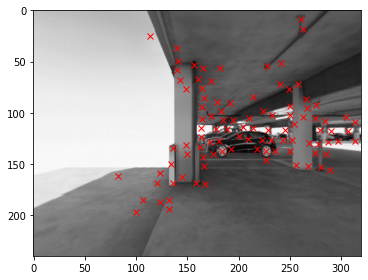

In [15]:
plt.figure()
skio.imshow(i0)
plt.plot(keypoints[:,1], keypoints[:,0], "rx")

In [16]:
def describe_keypoints(img, keypoints, r):
    # return image patches for the keypoints
    padded = np.pad(img, [r, r])
    side = 2*r + 1
    new_size = side**2
    return [np.reshape(padded[x:x+side, y:y+side], new_size) for x, y in keypoints]

In [17]:
descriptors = describe_keypoints(i0, keypoints, descriptor_radius)

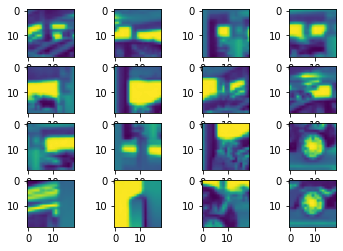

In [18]:
plt.figure()
for i in range(1, 17):
    plt.subplot(4, 4, i)
    patch_size = 2 * descriptor_radius + 1
    plt.imshow(np.reshape(descriptors[i], [patch_size, patch_size]))

In [ ]:
# TODO: match descriptors between images